#### Assignment 5 [Neural Networks]

Name: Zenas Huang

***Instructions:***

Implement the Back Propagation algorithm for Feed Forward Neural Networks to learn the down gestures from training instances available in downgesture_train.list. The *label of an image is 1 if the word "down" is in its file name; otherwise the label is 0*. The pixels of an image use the gray scale ranging from 0 to 1. In your network, use one input layer, one hidden layer of size 100, and one output perceptron.

Use the value 0.1 for the learning rate. For each perceptron, use the sigmoid function $Ɵ(s) = 1/(1+e^{-s})$. Use 1000 training epochs; initialize all the weights randomly between -0.01 and 0.01.

Use the trained network to predict the labels for the gestures in the test images available in downgesture_test.list. For the error function, use the standard squared error. Output your predictions and accuracy.

In [1]:
#Import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #for visualization aids
import cv2 #for reading the pgm image files

In [2]:
def preprocessData(fname):
    with open(fname) as file:
        filelist = file.read().splitlines()
        #build labels, 1 if filename has "down", otherwise label is 0
        labels = np.array([1.0 if "down" in k else 0.0 for k in filelist]).reshape(-1,1)
        #build input matrix of images for NN forward pass
        X = np.zeros((0,960)) #960 since each image is HxW = 30x32
        for i in filelist:
            #use cv2to read in pgm files with flag 0 so images are read as grayscale
            image = cv2.imread(i,0)
            #normalize pixel values to 0,1
            image = cv2.normalize(image,image, 0,1, norm_type = cv2.NORM_MINMAX)
            image = image.reshape(1,-1)
            #print(image.shape) #plt.imshow(image) #for debugging  
            X = np.concatenate((X,image),axis=0)
    return X, labels

In [3]:
#built the train and test image data and labels
train_files = 'downgesture_train.list.txt'
test_files = 'downgesture_test.list.txt'
X_train, labels_train = preprocessData(train_files)
X_test, labels_test = preprocessData(test_files)

In [4]:
class FeedForwardNN():
    def __init__(self, epochs = None, eta = None):
        self.epochs = epochs
        self.eta = eta
        #initialize layer weights randomly between -0.01 and 0.01, #d+1 features (HxW)+1 = 961 for input layer,
        self.layer1 = np.random.uniform(-0.01, 0.01,size=(961,100))  #one hidden layer size 100
        self.layer2 = np.random.uniform(-0.01, 0.01, size=(101,1))  #one output unit
#        self.layer1 = np.random.randn(961,100) #alternative initialization using draws from gaussian
#        self.layer2 = np.random.randn(101,1)
        self.s1, self.s2, self.activation1, self.activation2 = None, None, None, None
        self.costgrad1, self.costgrad2, self.d1, self.d2 = None, None, None, None
        self.losses, self.tlosses = [], []
        self.logits=None
        
    #constant 1 padding-op for complete logic operations 
    def pad(self,X):
        X = np.insert(X,0,1.0,axis=1)
        return X
    
    #sigmoid function for every perceptron
    def sigmoid(self,s):
        return 1.0/(1.0+np.exp(-s))
    
    #derivative of sigmoid activation for backprop
    def sigprime(self,s):
        sig = self.sigmoid(s)
        return sig * (1.0-sig)
          
    #forward pass through NN for predicted probabilities  
    def forwardfeed(self, X):
        self.s1 = np.dot(self.pad(X), self.layer1)
        self.activation1 = self.sigmoid(self.s1)
        self.s2 = np.dot(self.pad(self.activation1), self.layer2)
        self.activation2 = self.sigmoid(self.s2)
        return self.activation2
    
    #backpropagation
    def backpropagation(self, X, labels):
        #get costs and compute updates to each layer
        self.logits = self.forwardfeed(X)
        self.d2 = (self.logits - labels)*self.sigprime(self.s2) #derivative of 1/2*squared error function
        self.d1 = self.sigprime(self.pad(self.s1))*np.dot(self.d2, self.layer2.T)
        self.costgrad2 = np.dot(self.pad(self.s1).T, self.d2)/len(self.layer2)
        self.costgrad1 = np.dot(self.pad(X).T, self.d1)/len(self.layer1)
        #update layer weights
        self.layer2 = self.layer2  - self.eta * self.costgrad2
        self.layer1 = self.layer1 - self.eta * self.costgrad1[:,1:]

    #train the network
    def train(self,X,labels):
        for i in range(self.epochs):
            self.backpropagation(X,labels)
            #for visualization, track standard mean squared error loss for training and test in lists
            epochloss = np.mean((self.logits - labels)**2)
            tloss = np.mean((self.forwardfeed(X_test)- labels_test)**2)
            self.losses.append(epochloss)
            self.tlosses.append(tloss)
        return self
    
    #method to return 0-1 predictions
    def predict(self,X):
        preds = np.rint(self.forwardfeed(X))
        return preds

In [5]:
#fix random seed
np.random.seed(16)
#instantiate feed forward neural network to train for 1000 epochs with learning rate value of 0.1
ffNN = FeedForwardNN(epochs=1000,eta = 0.1)
#train the network on the training images and labels
ffNN.train(X_train,labels_train);

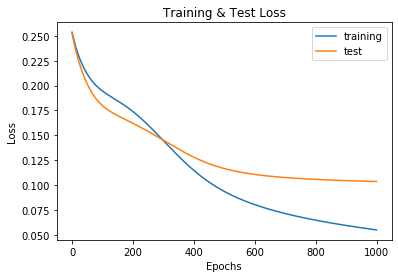

In [6]:
#Visualize MSE loss over epochs for early stopping if needed
plt.plot(ffNN.losses,label='training')
plt.plot(ffNN.tlosses,label='test')
plt.legend(loc='upper right')
plt.title('Training & Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show();

In [7]:
#Output Predictions on the test images & test Accuracy with confusion table.
predictions = ffNN.predict(X_test)
accuracy = np.count_nonzero(predictions == labels_test)/len(labels_test)*100
pred = pd.Series(np.squeeze(predictions), name='Predicted')
true = pd.Series(np.squeeze(labels_test),name = 'True Label')
df_confusion = pd.crosstab(true, pred, margins = True)
print('Accuracy: ', round(accuracy,2),'%')
print('NN Predictions: \n',predictions.reshape(1,-1))
print('Test Labels: \n', labels_test.reshape(1,-1))
df_confusion

Accuracy:  86.75 %
NN Predictions: 
 [[1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]]
Test Labels: 
 [[1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]]


Predicted,0.0,1.0,All
True Label,,,
0.0,61,3,64
1.0,8,11,19
All,69,14,83
